# Neuromatch Final Project

---

## Set-up

In [34]:
#imports
import os, requests
from matplotlib import rcParams
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np 
from nilearn import plotting  
from nimare import utils
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Reshape
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#Setting some parameters for the graphs
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

#Loading in the dataset
fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
    try:
        r =requests.get(url)
    except requests.ConnectionError:
        print("Failed to download data")
    else:
        if r.status_code != requests.codes.ok:
            print("Failed to download data")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

---
## Functions

In [ ]:
class process():
    def __init__():
        return

    def preprocess(data):
        V = data['V'].astype('float32')
        b, a = signal.butter(3, [50], btype = 'high', fs=1000)
        V = signal.filtfilt(b,a,V,0)
        V = np.abs(V)**2
        b, a = signal.butter(3, [10], btype = 'low', fs=1000)
        V = signal.filtfilt(b,a,V,0)
        V = V/V.mean(0)
        return V

class plots():
    def __init__():
        return

    def singlechannel1(data, channel):
        plt.figure(figsize=(20,10))
        plt.plot(trange, data[:,channel])
        plt.title('ch%d'%channel)
        plt.xticks([0, 1000, 2000])
        plt.ylim([0, 4])

    def singlechannel2(data, data2, channel):
        plt.figure(figsize=(20,10))
        plt.plot(trange, data[:,channel])
        plt.plot(trange, data2[:,channel])
        plt.title('ch%d'%channel)
        plt.xticks([0, 1000, 2000])
        plt.ylim([0, 4])

    def all_channels1(data):
        plt.figure(figsize=(20,10))
        for j in range(46):
            ax = plt.subplot(5,10,j+1)
            plt.plot(trange, data[:,j])
            plt.title('ch%d'%j)
            plt.xticks([0, 1000, 2000])
            plt.ylim([0, 4])

    def all_channels2(data, data2):
        plt.figure(figsize=(20,10))
        for j in range(46):
            ax = plt.subplot(5,10,j+1)
            plt.plot(trange, data[:,j])
            plt.plot(trange, data2[:,j])
            plt.title('ch%d'%j)
            plt.xticks([0, 1000, 2000])
            plt.ylim([0, 4])

---
## The Data We'll Work With

In [ ]:
alldat = np.load(fname, allow_pickle=True)['dat']

real = alldat[0][0]
imagine = alldat[0][1]


In [ ]:
processed_real = process.preprocess(real)
nt_pr, nchan_pr = processed_real.shape
nstim_r = len(real['t_on'])

trange = np.arange(0, 2000)
ts = real['t_on'][:,np.newaxis] + trange

V_epochs_pr = np.reshape(processed_real[ts, :], (nstim_r, 2000, nchan_pr))

V_hand_real = (V_epochs_pr[real['stim_id']==12])  #Change this to 11 to get tongue data and 12 to get hand data


##### This is the voltage data and you could change the trial from here
hand_real_data = V_hand_real.mean(0)





processed_imagine = process.preprocess(imagine)
nt_pi, nchan_pi = processed_imagine.shape
nstim_i = len(imagine['t_on'])

trange = np.arange(0, 2000)
ts = imagine['t_on'][:,np.newaxis] + trange

V_epochs_pi = np.reshape(processed_imagine[ts, :], (nstim_i, 2000, nchan_pi))

V_hand_imagine = (V_epochs_pi[imagine['stim_id']==12])



##### This is the voltage data and you could change the trial from here
hand_imagine_data = V_hand_imagine.mean(0)

---
## The Graphs

In [ ]:
plots.all_channels2(hand_real_data, hand_imagine_data)
plots.singlechannel1(hand_real_data, 13)
plots.singlechannel2(hand_real_data, hand_imagine_data, 1)

---

## The heatmaps

In [ ]:
#This is the data being put into the map
#data =  hand_real_data - hand_imagine_data 
data = hand_real_data
#data = hand_imagine_data
#data = hand_imagine_data - hand_real_data


#This is the time you want to see the data for
time = 1000


channels = []
size = []

for i in range(46):
    channels.append(data[:,i])

for i in range(46):
    size.append(channels[i][time] * 22  * np.sqrt(channels[i][time]))

plt.figure(figsize=(8,8))
locs = real['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = 'red', marker_size=size)
view

In [ ]:
#This is the data being put into the map
data =  hand_real_data - hand_imagine_data 
#data = hand_real_data
#data = hand_imagine_data
#data = hand_imagine_data - hand_real_data


#This is the time you want to see the data for
time = 1000


channels = []
size = []

for i in range(46):
    channels.append(data[:,i])

for i in range(46):
    size.append(channels[i][time] * 22  * np.sqrt(channels[i][time]))

plt.figure(figsize=(8,8))
locs = real['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = 'red', marker_size=size)
view

In [ ]:
#Change the number to different channels to see the Brodmann's area at that electrode
real['Brodmann_Area'][12]

---
## Logistic Regression

In [27]:

X=[]
for j in range(46):
  X.append(hand_real_data[:,j])
  X.append(hand_imagine_data[:,j])
X=np.array(X)

#real=0 imaginary=1
y=[]
for j in range(46):
  y.append(0)
  y.append(1)
y=np.array(y)

In [28]:
# Define the model
log_reg = LogisticRegression(penalty="none")
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation
print(accuracies)
accuracies.mean()
print(accuracies.mean())

# Fit it to data
log_reg.fit(X[0:60], y[0:60])

y_pred = log_reg.predict(X[60:92])
print(y_pred)

[1.         0.91666667 0.83333333 0.66666667 0.90909091 0.90909091
 1.         0.72727273]
0.8702651515151515
[0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1]


In [31]:
def compute_accuracy(X, y, model):
  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()
  return accuracy

# Compute training accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 95.65%


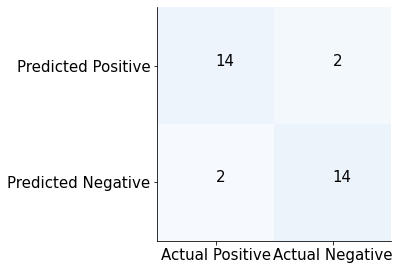

In [36]:
confusion = [[0.75,0.34],[0.12,0.98]]
y_true = y[60:92]
y_pred = y_pred
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#confusion = [[0.75,0.34],[0.12,0.98]]
fig, ax = plt.subplots(1,1)
ax.imshow(confusion,cmap='Blues',clim=[0,16])
plt.text(0,0,str(tn))
plt.text(0,1,str(fp))
plt.text(1,0,str(fn))
plt.text(1,1,str(tp))
x_label_list = ['Actual Positive','Actual Negative']
ax.set_xticks([0,1])
ax.set_xticklabels(x_label_list)
y_label_list = ['Predicted Positive','Predicted Negative']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)
plt.show()

#bottom left is False Negative
#top right is False Positive

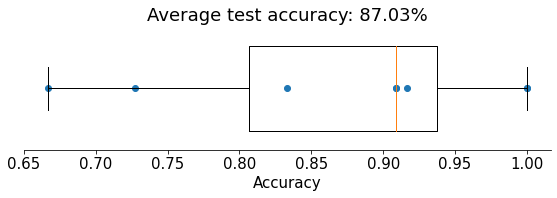

In [37]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [38]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Time (a.k.a. feature)")
  f.tight_layout()

def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Time steps", (C_values[0], n_voxels * .98), va="top")

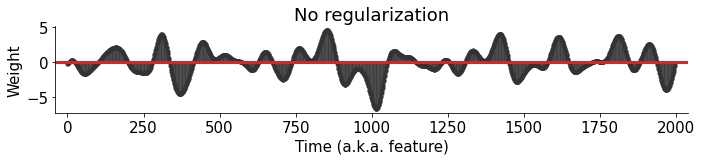

In [39]:
log_reg = LogisticRegression(penalty="none").fit(X, y)
plot_weights({"No regularization": log_reg})


---

## CNN

In [ ]:
#The dataset
specify_channel = 20

cnn_inputs_real = []
for i in range(30):
    abc = V_hand_real[i]
    cnn_inputs_real.append(abc[:, specify_channel])
#cnn_inputs_real is for real data. 1 is the label for real
cnn_inputs_real = np.array(cnn_inputs_real)
labels_real = np.ones((30))
labels_real = labels_real.reshape(30,1)


cnn_inputs_imagine = []
for i in range(30):
    abc = V_hand_imagine[i]
    cnn_inputs_imagine.append(abc[:, specify_channel])
#cnn_inputs_imagine is for imaginary data. 0 is the label for imaginary
cnn_inputs_imagine = np.array(cnn_inputs_imagine)
labels_imagine = np.zeros((30))
labels_imagine = labels_imagine.reshape(30,1) 


trainX = np.append(cnn_inputs_real[0:20], cnn_inputs_imagine[0:20], axis=0)
trainy = np.append(labels_real[0:20], labels_imagine[0:20], axis=0)

trainX = trainX.reshape([40,2000,1])

testX = np.append(cnn_inputs_real[20:30], cnn_inputs_imagine[20:30], axis=0)
testy = np.append(labels_real[20:30], labels_imagine[20:30], axis=0)
testX = testX.reshape([20,2000,1])


In [ ]:
#old CNN
def CNN(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    verbose = 1
    epochs = 200
    batch_size = 40
    model = Sequential()
    model.add(Conv1D(filters=100, kernel_size=50, activation='relu', input_shape=(n_timesteps,n_features)))
    #model.add(Conv1D(filters=100, kernel_size=100, activation='relu'))
    #model.add(MaxPooling1D())
    #model.add(Conv1D(filters=100, kernel_size=40, activation='sigmoid'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.05))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    accuracy = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return accuracy

In [ ]:
#Final CNN Model
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
verbose = 1
epochs = 200
batch_size = 40
model = Sequential()
model.add(Conv1D(filters=75, kernel_size=45, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=75, kernel_size=30, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.003))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historyyy = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(testX, testy))

In [ ]:
plt.plot(historyyy.history['accuracy'])
plt.plot(historyyy.history['loss'])
plt.show()
plt.plot(historyyy.history['val_accuracy'])
plt.plot(historyyy.history['val_loss'])
plt.show()

In [ ]:
CNN(trainX, trainy, testX, testy)